In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
df=pd.read_csv("//content//drive//MyDrive//Xav//Sem 3//Assignments//adv.csv")

In [3]:
df.head()

,Entity,Code,Year,Period life expectancy at birth,GDP per capita,900793-annotations,Population (historical),World regions according to OWID
0,Afghanistan,AFG,2014,62.2599,2022.0000,NaN,32792528.0,NaN
1,Afghanistan,AFG,2015,62.2695,1928.0000,NaN,33831767.0,NaN
2,Afghanistan,AFG,2016,62.6459,1931.2438,NaN,34700613.0,NaN
3,Afghanistan,AFG,2017,62.4062,1909.7330,NaN,35688941.0,NaN
4,Afghanistan,AFG,2018,62.4434,1888.8140,NaN,36743040.0,NaN


In [4]:
df.shape

(2855, 8)

In [5]:
df = df[['Period life expectancy at birth', 'GDP per capita']].copy()

In [6]:
df = df.rename(columns={
    'Period life expectancy at birth': 'Life_expectancy',
    'GDP per capita': 'GDP_per_capita'
})

In [7]:
print("Missing in Life_expectancy:", df['Life_expectancy'].isna().sum())
print("Missing in GDP_per_capita:", df['GDP_per_capita'].isna().sum())

Missing in Life_expectancy: 245
Missing in GDP_per_capita: 1262


In [8]:
df = df.dropna(subset=['Life_expectancy', 'GDP_per_capita'])
print(df.shape)

(1493, 2)


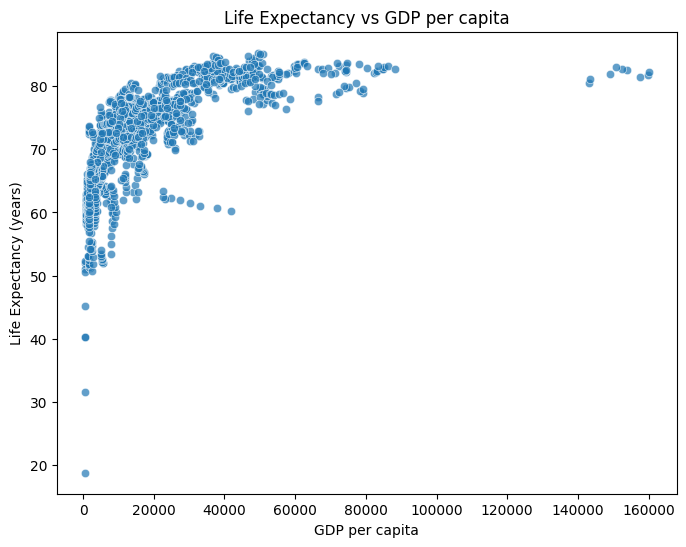

In [9]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='GDP_per_capita', y='Life_expectancy', data=df, alpha=0.7)
plt.title("Life Expectancy vs GDP per capita")
plt.xlabel("GDP per capita")
plt.ylabel("Life Expectancy (years)")
plt.show()

In [10]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

df_clean = remove_outliers_iqr(df, 'GDP_per_capita')
df_clean = remove_outliers_iqr(df_clean, 'Life_expectancy')

print("Number of rows before cleaning:", len(df))
print("Number of rows after cleaning:", len(df_clean))

Number of rows before cleaning: 1493
Number of rows after cleaning: 1438


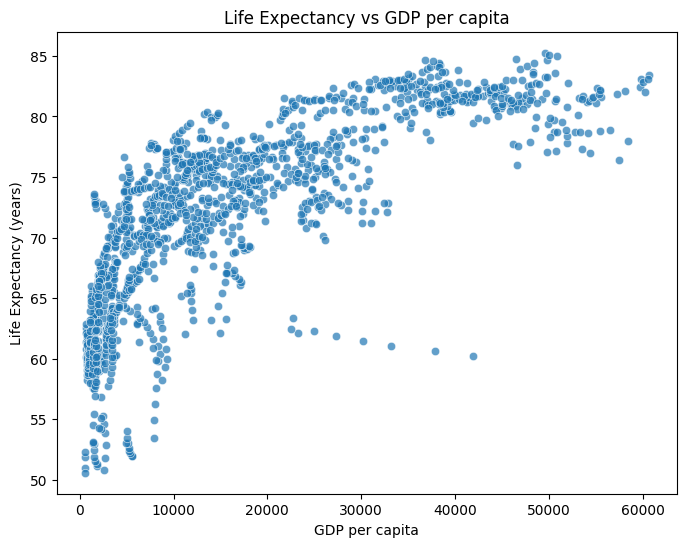

In [11]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='GDP_per_capita', y='Life_expectancy', data=df_clean, alpha=0.7)
plt.title("Life Expectancy vs GDP per capita")
plt.xlabel("GDP per capita")
plt.ylabel("Life Expectancy (years)")
plt.show()

In [12]:
df_clean['log_GDP'] = np.log(df_clean['GDP_per_capita'])

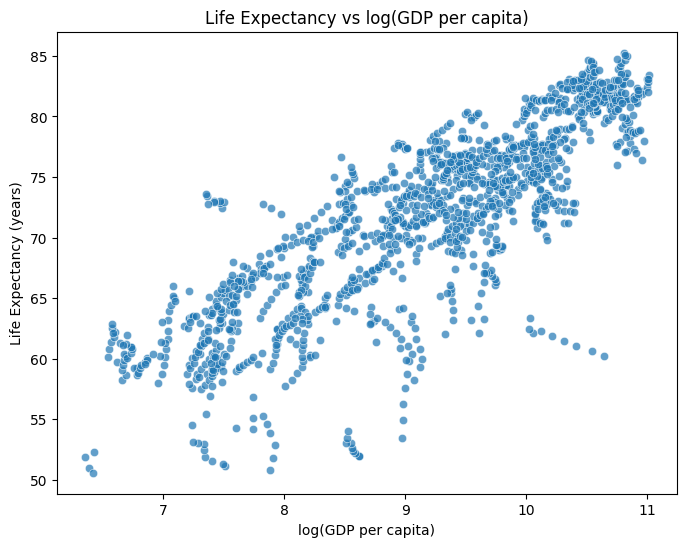

In [13]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='log_GDP', y='Life_expectancy', data=df_clean, alpha=0.7)
plt.title("Life Expectancy vs log(GDP per capita)")
plt.xlabel("log(GDP per capita)")
plt.ylabel("Life Expectancy (years)")
plt.show()

In [14]:
df_clean

,Life_expectancy,GDP_per_capita,log_GDP
0,62.2599,2022.0000,7.611842
1,62.2695,1928.0000,7.564238
2,62.6459,1931.2438,7.565920
3,62.4062,1909.7330,7.554719
4,62.4434,1888.8140,7.543704
...,...,...,...
2849,60.9055,1900.1992,7.549714
2850,61.0603,1753.0244,7.469098
2851,61.5300,1585.9728,7.368953
2852,60.1347,1687.2532,7.430857


In [15]:
X = df_clean[['log_GDP']]
Y = df_clean[['Life_expectancy']]

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 1150
Test size: 288


 **Bin Smoother**

In [16]:
class StepFunction:
    def __init__(self, x, y):
        """
        Initialize with breakpoints `x` and values `y`.
        `x` should have length k+1 and `y` should have length k.
        """
        if len(y) != len(x) - 1:
            raise ValueError("Length of y must be one less than length of x")
        self.x = x
        self.y = y

    def predict(self, z):
        # Predict step function value at z (scalar or array).
        z = np.asarray(z)
        result = np.zeros_like(z, dtype=float)
        for i in range(len(self.y)):
            result[(z >= self.x[i]) & (z < self.x[i + 1])] = self.y[i]
        result[z >= self.x[-1]] = self.y[-1]
        return result

In [17]:
def Bin_smoothing(k, x_train, y_train, x_val, y_val):
    BI = np.linspace(x_train.min(), x_train.max(), k + 1)
    Means = []
    for j in range(k):
        indices = np.where((x_train > BI[j]) & (x_train <= BI[j + 1]))[0]
        m = np.mean(y_train[indices]) if len(indices) > 0 else np.nan
        Means.append(m)
    Means = np.nan_to_num(Means, nan=np.nanmean(y_train))
    sf = StepFunction(BI, Means)
    y_pred = sf.predict(x_val)
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    return mse, mae

In [18]:
x = X_train['log_GDP'].to_numpy()
y = y_train.to_numpy()

In [19]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
bin_counts = [3, 5, 8, 10, 15, 20]
results = []

In [20]:
for k in bin_counts:
    mse_list, mae_list = [], []
    for train_idx, val_idx in kf.split(x):
        x_tr, x_val = x[train_idx], x[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        mse, mae = Bin_smoothing(k, x_tr, y_tr, x_val, y_val)
        mse_list.append(mse)
        mae_list.append(mae)

    results.append({
        "Bins": k,
        "CV_MSE": np.mean(mse_list),
        "CV_MAE": np.mean(mae_list)
    })

cv_results = pd.DataFrame(results)
print("\nCross-Validation Results:")
print(cv_results)
# Removed: cv_results['Bins'==best_bin] # This line caused a KeyError


Cross-Validation Results:
   Bins     CV_MSE    CV_MAE
0     3  28.998565  3.985778
1     5  22.917349  3.296214
2     8  21.931535  3.124075
3    10  22.214918  3.209580
4    15  21.408509  3.072647
5    20  21.447869  3.086283


In [21]:
best_bin = cv_results.loc[cv_results["CV_MSE"].idxmin(), "Bins"]
print(f"✅ Optimal number of bins (based on lowest CV MSE): {best_bin}")

# Extract best CV MSE for Bin Smoother
best_bin_cv_mse = cv_results.loc[cv_results["Bins"] == best_bin, "CV_MSE"].iloc[0]

# Calculate Test MSE and MAE for Bin Smoother with optimal bins
# Ensure X_test and y_test are numpy arrays for the Bin_smoothing function
X_test_np = X_test['log_GDP'].to_numpy()
y_test_np = y_test.to_numpy()

bin_test_mse, bin_test_mae = Bin_smoothing(best_bin, x, y, X_test_np, y_test_np) # x, y are X_train, y_train as numpy
print(f"\n📊 Bin Smoother Test MSE: {bin_test_mse:.4f}")
print(f"📊 Bin Smoother Test MAE: {bin_test_mae:.4f}")

✅ Optimal number of bins (based on lowest CV MSE): 15

📊 Bin Smoother Test MSE: 16.3646
📊 Bin Smoother Test MAE: 2.8913


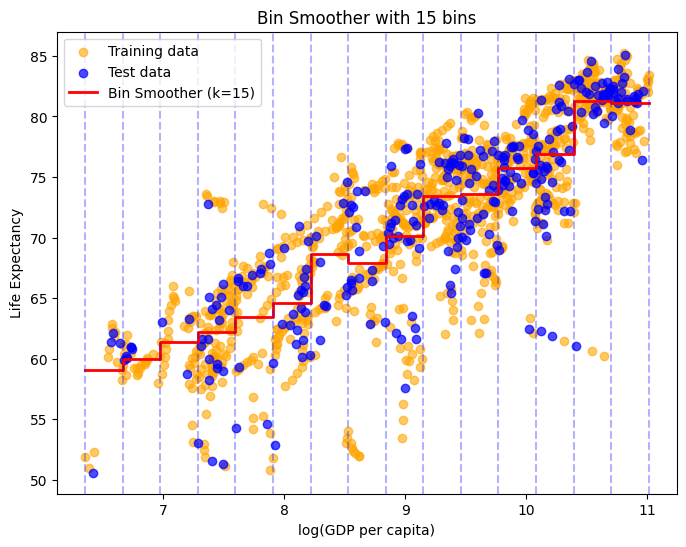

In [22]:
X = df_clean['log_GDP'].to_numpy()
Y = df_clean['Life_expectancy'].to_numpy()

# Compute bin edges and means again using optimal k
bin_edges = np.linspace(X.min(), X.max(), best_bin + 1)
bin_means = []

for j in range(best_bin):
    indices = np.where((X > bin_edges[j]) & (X <= bin_edges[j+1]))[0]
    m = np.mean(Y[indices]) if len(indices) > 0 else np.nan
    bin_means.append(m)

# Create the step function manually for visualization
x_plot = []
y_plot = []
for j in range(best_bin):
    x_plot.extend([bin_edges[j], bin_edges[j+1]])
    y_plot.extend([bin_means[j], bin_means[j]])

# Plot the original data
plt.figure(figsize=(8, 6))
#plt.scatter(X, Y, color='orange', alpha=0.6, label='Data')
plt.scatter(X_train, y_train, color='orange', alpha=0.6, label='Training data')
plt.scatter(X_test, y_test, color='blue', alpha=0.7, label='Test data')

# Plot the bin smoother
plt.plot(x_plot, y_plot, color='red', lw=2, label=f'Bin Smoother (k={best_bin})')

# Plot vertical lines for bin boundaries
for edge in bin_edges:
    plt.axvline(edge, color='blue', linestyle='--', alpha=0.3)

plt.xlabel("log(GDP per capita)")
plt.ylabel("Life Expectancy")
plt.title(f"Bin Smoother with {best_bin} bins")
plt.legend()
plt.show()

**KNN Smoother**

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assume df already cleaned and has columns 'log_GDP' and 'Life_Expectancy'
X = df_clean[['log_GDP']]
y = df_clean['Life_expectancy']

# -------------------- Train-Test Split (80/20) --------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------- Cross-Validation Function --------------------
def knn_cv(X, y, k_list, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = []

    for k in k_list:
        fold_mse = []
        fold_mae = []
        for train_index, val_index in kf.split(X):
            X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
            y_tr, y_val = y.iloc[train_index], y.iloc[val_index]

            model = KNeighborsRegressor(n_neighbors=k)
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_val)

            fold_mse.append(mean_squared_error(y_val, y_pred))
            fold_mae.append(mean_absolute_error(y_val, y_pred))

        results.append([k, np.mean(fold_mse), np.mean(fold_mae)])
    return pd.DataFrame(results, columns=['k', 'CV_MSE', 'CV_MAE'])

In [24]:
# -------------------- Run Cross-Validation --------------------
k_list = [3, 5, 10, 15, 20, 25, 30, 35]
knn_results = knn_cv(X_train, y_train, k_list)
knn_results

,k,CV_MSE,CV_MAE
0,3,21.349037,3.327739
1,5,18.636430,3.154823
2,10,17.111652,3.022842
3,15,16.835173,2.998010
4,20,16.483077,2.955018
5,25,16.260663,2.933038
6,30,16.377128,2.940301
7,35,16.335465,2.935816


In [25]:
# -------------------- Select Best k --------------------
best_k = knn_results.loc[knn_results['CV_MSE'].idxmin(), 'k']
best_knn_cv_mse = knn_results['CV_MSE'].min() # Store best CV MSE
print("✅ Optimal k based on CV MSE:", best_k)

# -------------------- Evaluate on Test Set --------------------
best_knn = KNeighborsRegressor(n_neighbors=int(best_k))
best_knn.fit(X_train, y_train)
y_test_pred = best_knn.predict(X_test)

knn_test_mse = mean_squared_error(y_test, y_test_pred) # Renamed
knn_test_mae = mean_absolute_error(y_test, y_test_pred) # Renamed
print(f"📊 Test MSE: {knn_test_mse:.4f}") # Updated print statement
print(f"📊 Test MAE: {knn_test_mae:.4f}") # Updated print statement

✅ Optimal k based on CV MSE: 25
📊 Test MSE: 16.8815
📊 Test MAE: 2.9611


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


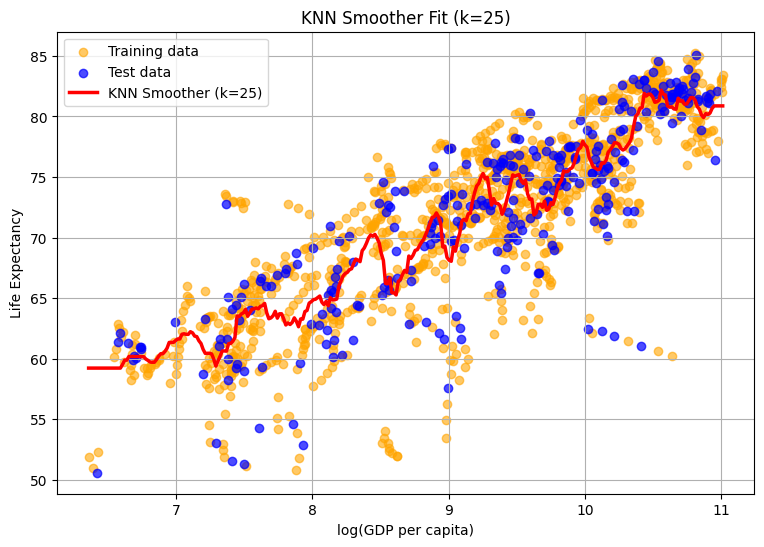

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor

# Refit KNN model using best_k on full training data
best_knn = KNeighborsRegressor(n_neighbors=int(best_k))
best_knn.fit(X_train, y_train)

# Create a smooth range of X values for plotting
X_plot = np.linspace(X['log_GDP'].min(), X['log_GDP'].max(), 300).reshape(-1, 1)
y_plot = best_knn.predict(X_plot)

# Plot the original data and smoother
plt.figure(figsize=(9,6))
plt.scatter(X_train, y_train, color='orange', alpha=0.6, label='Training data')
plt.scatter(X_test, y_test, color='blue', alpha=0.7, label='Test data')
plt.plot(X_plot, y_plot, color='red', linewidth=2.5, label=f'KNN Smoother (k={best_k})')

plt.xlabel("log(GDP per capita)")
plt.ylabel("Life Expectancy")
plt.title(f"KNN Smoother Fit (k={best_k})")
plt.legend()
plt.grid(True)
plt.show()

**LOWESS Smoother**

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.nonparametric.smoothers_lowess import lowess

# -------------------- Data Split --------------------
X = df_clean['log_GDP'].values
y = df_clean['Life_expectancy'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------- LOESS Prediction Function --------------------
def loess_predict(X_train, y_train, X_pred, frac):
    fitted = lowess(y_train, X_train, frac=frac, return_sorted=True)
    x_fit, y_fit = fitted[:, 0], fitted[:, 1]
    return np.interp(X_pred, x_fit, y_fit)

# -------------------- Cross-Validation --------------------
frac_values = np.round(np.linspace(0.05, 0.95, 19), 2)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

for frac in frac_values:
    fold_mse, fold_mae = [], []
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        y_val_pred = loess_predict(X_tr, y_tr, X_val, frac)
        fold_mse.append(mean_squared_error(y_val, y_val_pred))
        fold_mae.append(mean_absolute_error(y_val, y_val_pred))
    results.append([frac, np.mean(fold_mse), np.mean(fold_mae)])

# Convert to DataFrame
loess_results = pd.DataFrame(results, columns=['Span (frac)', 'CV_MSE', 'CV_MAE'])
loess_results_sorted = loess_results.sort_values(by='CV_MSE').reset_index(drop=True)

# Display table
print("📊 Cross-Validation Results for LOESS Smoother:")
print(loess_results)

📊 Cross-Validation Results for LOESS Smoother:
    Span (frac)     CV_MSE    CV_MAE
0          0.05  17.206924  2.879329
1          0.10  17.150615  2.877992
2          0.15  17.319131  2.903164
3          0.20  17.409623  2.928365
4          0.25  17.430408  2.946032
5          0.30  17.487901  2.967046
6          0.35  17.559492  2.989320
7          0.40  17.606255  3.000082
8          0.45  17.638762  3.009623
9          0.50  17.655721  3.015815
10         0.55  17.673851  3.020343
11         0.60  17.700039  3.025932
12         0.65  17.710970  3.029823
13         0.70  17.723621  3.033040
14         0.75  17.741522  3.036236
15         0.80  17.746913  3.037494
16         0.85  17.743909  3.037182
17         0.90  17.734207  3.036566
18         0.95  17.724241  3.035694


In [28]:
# -------------------- Best frac selection --------------------
best_frac = loess_results_sorted.loc[0, 'Span (frac)']
print(f"✅ Optimal span (frac): {best_frac:.2f}")

✅ Optimal span (frac): 0.10


In [29]:
# -------------------- Test Evaluation --------------------
y_test_pred = loess_predict(X_train, y_train, X_test, best_frac)
loess_test_mse = mean_squared_error(y_test, y_test_pred) # Renamed
loess_test_mae = mean_absolute_error(y_test, y_test_pred) # Renamed
best_loess_cv_mse = loess_results_sorted.loc[0, 'CV_MSE'] # Store best CV MSE
print(f"📈 Test MSE: {loess_test_mse:.5f}") # Updated print statement
print(f"📈 Test MAE: {loess_test_mae:.5f}") # Updated print statement

📈 Test MSE: 16.63680
📈 Test MAE: 2.82999


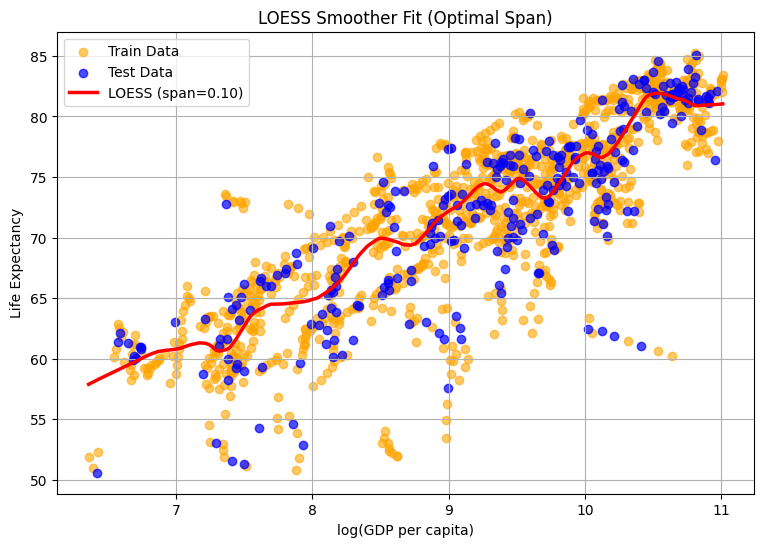

In [30]:
# -------------------- Plot Final LOESS Fit --------------------
x_plot = np.linspace(X.min(), X.max(), 300)
y_plot = loess_predict(X_train, y_train, x_plot, best_frac)

plt.figure(figsize=(9,6))
plt.scatter(X_train, y_train, color='orange', alpha=0.6, label='Train Data')
plt.scatter(X_test, y_test, color='blue', alpha=0.7, label='Test Data')
plt.plot(x_plot, y_plot, color='red', linewidth=2.5, label=f'LOESS (span={best_frac:.2f})')
plt.xlabel("log(GDP per capita)")
plt.ylabel("Life Expectancy")
plt.title("LOESS Smoother Fit (Optimal Span)")
plt.legend()
plt.grid(True)
plt.show()

**Kernel Smoother**

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Data Split
X = df_clean['log_GDP'].values
y = df_clean['Life_expectancy'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Kernel regression function
def kernel_regression(X_train, y_train, X_test, h, kernel_func):
    preds = []
    for x in X_test:
        weights = kernel_func((x - X_train) / h)
        # Handle cases where all weights are zero (e.g., if h is too small or x is an outlier)
        if np.sum(weights) == 0:
            # Fallback: predict the mean of y_train or a nearby point, or handle as NaN
            # For simplicity, returning NaN, which will be filtered out during MSE calculation
            preds.append(np.nan)
        else:
            preds.append(np.sum(weights * y_train) / np.sum(weights))
    return np.array(preds)

# Define kernel functions
def gaussian_kernel(u): return np.exp(-0.5 * u**2)
def epanechnikov_kernel(u): return np.where(np.abs(u) <= 1, 0.75*(1-u**2), 0)
def uniform_kernel(u): return np.where(np.abs(u) <= 1, 0.5, 0)
def triweight_kernel(u): return np.where(np.abs(u)<=1, (35/32)*(1-u**2)**3, 0)
def quartic_kernel(u): return np.where(np.abs(u)<=1, (15/16)*(1-u**2)**2, 0)

# Kernel set
kernels = {
    "Gaussian": gaussian_kernel,
    "Epanechnikov": epanechnikov_kernel,
    "Uniform": uniform_kernel,
    "Triweight": triweight_kernel,
    "Quartic": quartic_kernel
}

# Bandwidth range and 5-fold CV setup
bandwidths = np.linspace(0.1, 1.0, 10)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize trackers
best_overall = None
best_h = None
best_kernel_func = None
lowest_mse = float('inf')
kernel_results = []

# Cross-validation for each kernel & bandwidth
for name, kernel_func in kernels.items():
    for h in bandwidths:
        mse_folds = []
        for train_idx, val_idx in kf.split(X_train):
            Xtr, Xval = X_train[train_idx], X_train[val_idx] # Fixed: Changed .iloc to direct indexing
            ytr, yval = y_train[train_idx], y_train[val_idx] # Fixed: Changed .iloc to direct indexing
            y_pred_val = kernel_regression(Xtr, ytr, Xval, h, kernel_func)
            # Filter out NaN values from predictions and corresponding actual values
            valid_preds_mask = ~np.isnan(y_pred_val)
            if np.any(valid_preds_mask):
                mse_folds.append(mean_squared_error(yval[valid_preds_mask], y_pred_val[valid_preds_mask]))
            else:
                mse_folds.append(np.inf) # If no valid predictions, set MSE to infinity

        avg_mse = np.mean(mse_folds)
        kernel_results.append([name, h, avg_mse])
        if avg_mse < lowest_mse:
            lowest_mse = avg_mse
            best_overall = {"Kernel": name, "CV_MSE": avg_mse}
            best_h = h
            best_kernel_func = kernel_func

# Convert to DataFrame
kernel_results_df = pd.DataFrame(kernel_results, columns=['Kernel', 'Bandwidth', 'CV_MSE'])

In [32]:
# Show cross-validation summary
print("\n📊 Cross-validation results (sample):")
print(kernel_results_df.head())
print("\n✅ Best Kernel:", best_overall["Kernel"])
print(f"Optimal Bandwidth (h): {best_h:.3f}")
print(f"CV MSE: {best_overall['CV_MSE']:.5f}")


📊 Cross-validation results (sample):
     Kernel  Bandwidth     CV_MSE
0  Gaussian        0.1  16.304736
1  Gaussian        0.2  16.954821
2  Gaussian        0.3  17.236399
3  Gaussian        0.4  17.558733
4  Gaussian        0.5  18.017842

✅ Best Kernel: Epanechnikov
Optimal Bandwidth (h): 0.100
CV MSE: 15.94282


In [33]:
# Compute Test MSE & MAE
y_pred_test = kernel_regression(X_train, y_train, X_test, best_h, best_kernel_func)
valid_preds_test_mask = ~np.isnan(y_pred_test)
kernel_test_mse = mean_squared_error(y_test[valid_preds_test_mask], y_pred_test[valid_preds_test_mask])
kernel_test_mae = mean_absolute_error(y_test[valid_preds_test_mask], y_pred_test[valid_preds_test_mask])

print("📈 Test Performance:")
print(f"Test MSE: {kernel_test_mse:.5f}")
print(f"Test MAE: {kernel_test_mae:.5f}")

📈 Test Performance:
Test MSE: 15.97688
Test MAE: 2.85172


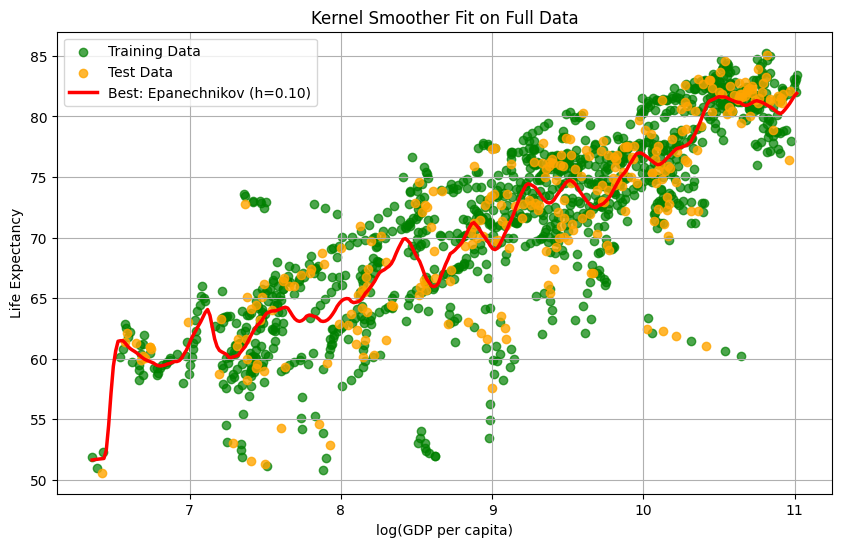

In [34]:
# ------------------------------------------------------------
# PLOT — Best Kernel Smoother on Full Data
# ------------------------------------------------------------
x_full = np.linspace(X.min(), X.max(), 300)
y_smooth = kernel_regression(X_train, y_train, x_full, best_h, best_kernel_func)

# Filter out NaN from y_smooth for plotting if any
valid_plot_mask = ~np.isnan(y_smooth)

plt.figure(figsize=(10,6))
plt.scatter(X_train, y_train, color='green', label='Training Data', alpha=0.7)
plt.scatter(X_test, y_test, color='orange', label='Test Data', alpha=0.8)
plt.plot(x_full[valid_plot_mask], y_smooth[valid_plot_mask], color='red', linewidth=2.5,
         label=f'Best: {best_overall["Kernel"]} (h={best_h:.2f})')
plt.xlabel("log(GDP per capita)")
plt.ylabel("Life Expectancy")
plt.title("Kernel Smoother Fit on Full Data")
plt.legend()
plt.grid(True)
plt.show()

In [35]:
# ------------------------------------------------------------
# MODEL COMPARISON TABLE
# ------------------------------------------------------------

comparison = pd.DataFrame({
    'Method': ['Bin Smoother', 'KNN Smoother', 'LOESS', 'Kernel Smoother'],
    'Best Hyperparameter': [
        f'{best_bin} bins',
        f'k = {best_k}',
        f'span = {best_frac}',
        f'{best_overall["Kernel"]}, h = {best_h:.2f}'
    ],
    'CV_MSE': [
        best_bin_cv_mse,         # from Bin Smoother CV
        best_knn_cv_mse,         # from KNN CV
        best_loess_cv_mse,       # from LOESS CV
        best_overall['CV_MSE']   # from Kernel CV
    ],
    'Test_MSE': [
        bin_test_mse,
        knn_test_mse,
        loess_test_mse,
        kernel_test_mse
    ],
    'Test_MAE': [
        bin_test_mae,
        knn_test_mae,
        loess_test_mae,
        kernel_test_mae
    ]
})

comparison = comparison.sort_values(by='Test_MSE').reset_index(drop=True)
print("\n🏆 Model Comparison Summary:")
display(comparison)


🏆 Model Comparison Summary:


,Method,Best Hyperparameter,CV_MSE,Test_MSE,Test_MAE
0,Kernel Smoother,"Epanechnikov, h = 0.10",15.942825,15.976884,2.851715
1,Bin Smoother,15 bins,21.408509,16.364587,2.891315
2,LOESS,span = 0.1,17.150615,16.636797,2.829989
3,KNN Smoother,k = 25,16.260663,16.881535,2.961065
